In [1]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split
from hyperopt import hp
import imp

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

RDKit WARNING: [17:18:51] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from modules.data import data_maker
from modules.RNN import double_RNN
from modules.fit import Model, fit, predict, mae, rmse, save
from modules.myhyperopt import hyperopt_func
from modules.MPNN import double_MPNN

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

In [4]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
CV_datasets = data_maker(solute, solvent, pka, CV_ids)
datasets = data_maker(solute, solvent, pka)

In [5]:
RF_desc = Model(name='Random forest with descriptors',
                  model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                  model_type='sklearn',
                  data_type='descriptors')
RF_ECFP = Model(name='Random forest with ECFP',
                  model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                  model_type='sklearn',
                  data_type='ECFP')
MLP_desc = Model(name='MLP with descriptors',
                  model=MLPRegressor(activation='logistic', batch_size=32, early_stopping=True, hidden_layer_sizes=(512, 256, 128), solver='adam'),
                  model_type='sklearn',
                  data_type='descriptors')
MLP_ECFP = Model(name='MLP with ECFP',
                  model=MLPRegressor(activation='relu', batch_size=16, early_stopping=True, hidden_layer_sizes=(256, 128, 64), solver='adam'),
                  model_type='sklearn',
                  data_type='ECFP')
RGB_desc = Model(name='RGBoost with descriptors',
                  model=XGBRegressor(colsample_bytree=0.7, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.9),
                  model_type='sklearn',
                  data_type='descriptors')
RGB_ECFP = Model(name='RGBoost with ECFP',
                  model=XGBRegressor(colsample_bytree=0.6, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.8),
                  model_type='sklearn',
                  data_type='ECFP')
#list of all models for testing
models = [RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, RGB_desc, RGB_ECFP]

In [6]:
#TODO: holdout data test
exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = fit(m, data, holdout_ids, exp_name)
    
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])
    
    save_model(m, exp_name)

holdout_test = pd.DataFrame(results)
print(holdout_test)

testing Random forest with descriptors ...
testing Random forest with ECFP ...
testing MLP with descriptors ...
testing MLP with ECFP ...
testing RGBoost with descriptors ...
testing RGBoost with ECFP ...
                            Model   MAE  RMSE
0  Random forest with descriptors 1.217 2.056
1         Random forest with ECFP 1.389 2.292
2            MLP with descriptors 1.146 1.752
3                   MLP with ECFP 1.397 2.130
4        RGBoost with descriptors 0.978 1.579
5               RGBoost with ECFP 1.221 1.844


Random forest with descriptors


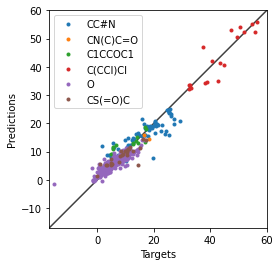

Random forest with ECFP


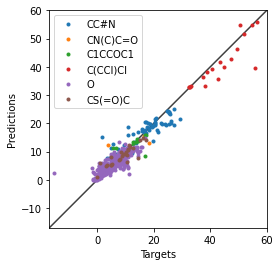

MLP with descriptors


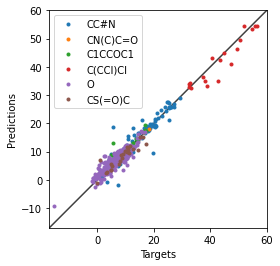

MLP with ECFP


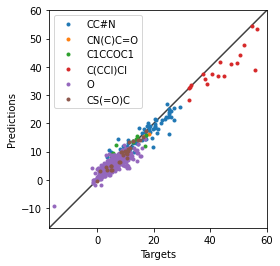

RGBoost with descriptors


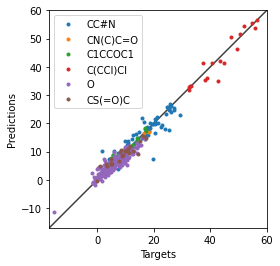

RGBoost with ECFP


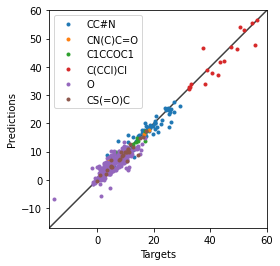

In [7]:
solv_set = list(set(solvent))
solv_ids = ddict()
for solv in solv_set:
    solv_ids[solv] = [i for i,x in enumerate(solvent) if x == solv and i in holdout_ids]
for m in models:
    print(m.name)
    for solv in solv_set:
        data = datasets[m.data_type]
        targets, outputs = predict(m, "Holdout test", data, solv_ids[solv])
        plt.plot(targets, outputs, 'o', markersize=3,label=solv)
        
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    lims = [-17,60]
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axes=plt.gca()
    axes.set_aspect('equal')
    axes.set_xlim(lims)
    axes.set_ylim(lims)
    axes.legend()
    plt.show()

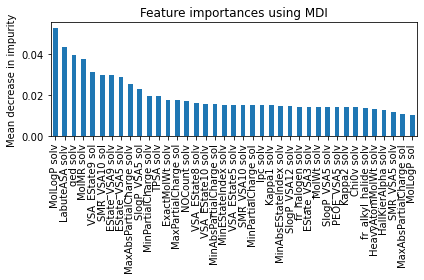

In [8]:
exp = RF_desc.experiments["Holdout test"]["model"]
#sorted_idx = exp.feature_importances_.argsort()

featuriser = dc.feat.RDKitDescriptors()
sol = featuriser.featurize('CC')
features = featuriser.descriptors
sol_features = [feat+' sol' for feat in features]
solv_features = [feat+' solv' for feat in features]
feature_names = sol_features+solv_features

forest_importances = pd.Series(exp.feature_importances_, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)
tops = forest_importances[forest_importances > 0.01]

fig, ax = plt.subplots()
tops.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

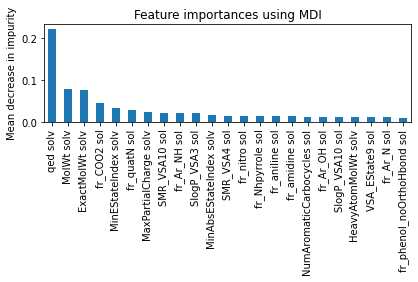

In [9]:
exp = RGB_desc.experiments["Holdout test"]["model"]
#sorted_idx = exp.feature_importances_.argsort()

forest_importances = pd.Series(exp.feature_importances_, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)
tops = forest_importances[forest_importances > 0.01]

fig, ax = plt.subplots()
tops.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()